In [264]:
import copy
import random
from types import SimpleNamespace

import vrplib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxIterations

In [265]:
%matplotlib inline
SEED = 1234

# Implementation of wang 2024
https://www.sciencedirect.com/science/article/pii/S0360835224002432?via%3Dihub

NOTE: data['dimension'] is the number of customers only, not including depots

In [266]:
def cost_matrix_from_coords(coords: list) -> list:
    """
    Create a cost matrix from a list of coordinates. Uses the Euclidean distance as cost.
    """
    n = len(coords)
    cost_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cost_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
    return cost_matrix

In [267]:
def read_cordeau_data(file: str, print_data: bool = False) -> dict:
    """
    Read the Cordeau et al. (2001) benchmark data.
    """
    filename = file.split('/')[-1]
    data_file = open(file, "r")
    if print_data:
        print("Reading data from file: ", filename)
    data = data_file.readlines()
    data_file.close()

    # Read problem type, number of vehicles, number of customers and number of days/depots/vehicle types
    # according to: https://www.bernabe.dorronsoro.es/vrp/

    type_dict = {
        0: 'VRP',
  	  	1: 'PVRP',
  	  	2: 'MDVRP',
  	  	3: 'SDVRP',
  	  	4: 'VRPTW',
  	  	5: 'PVRPTW',
  	  	6: 'MDVRPTW',
  	  	7: 'SDVRPTW'
        }

    key = data[0].split()[0]
    problem_type = type_dict.get(key)       # Problem type
    problem_type = type_dict.get(6)
    m = int(data[0].split()[1])     #number of vehicles
    n = int(data[0].split()[2])     #number of customers
    t = int(data[0].split()[3])     #number of days/depots/vehicle types

    # Save depots max duration and max load in array
    depots_info = []
    for i in range(t):
        line = data[i+1]
        depots_info.append(line.split())

    # Save customers in array
    customers = []
    for i in range(n):
        line = data[t+1+i]
        customers.append(line.split())

    customers = np.array(customers, dtype=np.float64)

    # Save depots in array
    depots = []
    for i in range(t):
        line = data[t+1+n+i]
        depots.append(line.split())

    depots = np.array(depots, dtype=np.float64)

    # Save in dict structure
    data_dict = {}
    data_dict['name'] = filename
    data_dict['vehicles'] = m
    data_dict['capacity'] = int(depots_info[0][1])
    data_dict['dimension'] = n      # Number of customers only, not depots
    data_dict['n_depots'] = t
    data_dict['depot_to_vehicles'] = {} # {depot: [vehicles]}
    data_dict['vehicle_to_depot'] = {} # {vehicle: depot}
    data_dict['depots'] = [i for i in range(n, n+t)]
    data_dict['node_coord'] = np.array([rows[1:3] for rows in customers])
    data_dict['node_coord'] = np.append(data_dict['node_coord'], np.array([rows[1:3] for rows in depots]), axis=0)
    data_dict['demand'] = [int(row[4]) for row in customers]
    data_dict['demand'] = np.array(data_dict['demand'] + [0 for row in depots])
    begin_times = [row[11] for row in customers]
    end_times = [row[12] for row in customers]
    data_dict['time_window'] = [[a, b] for a,b in zip(begin_times, end_times)]

    data_dict['service_time'] = [row[3] for row in customers]
    data_dict['service_time'] += [row[3] for row in depots]
    data_dict['edge_weight'] = cost_matrix_from_coords(data_dict['node_coord'])

    if print_data:
        print("Problem type: ", problem_type)
        print("Number of vehicles: ", m)
        print("Number of customers: ", n)
        print("Number of days/depots/vehicle types: ", t)

    return data_dict

In [268]:
data = read_cordeau_data("./data/c-mdvrptw/pr05", print_data=True)

Reading data from file:  pr05
Problem type:  MDVRPTW
Number of vehicles:  6
Number of customers:  240
Number of days/depots/vehicle types:  4


In [269]:
print(data['depots'])

[240, 241, 242, 243]


In [270]:
print(data["demand"])
print(type(data["demand"]))

[10 25 18 16 14  7  9 16 24  6 22 11 19 20 20 16  5 21 19 18 22 19 15 24
 20 17 20 12 23 15 19 23  9 21 17  6 10  9 19 17 22  8 25 13  1 15 16 20
 14  2  5 16 12  1 15  5  9  8  2 10 25 24  7 14  3 23 21 13 15 14  7 20
  6 24 17  3 15  6 21 25 18  1 19 17 20  1 13 25 16  5 18 17 15 13 15  2
  1  9 16  6 18 24 24  9 19 12 22 13 20 25  1 24 10 22 14 12 23 14 23 25
  5  7 25 11 18 18  1  7 22  7  3 18  8  6  7 20 10  2  3 10  5 25 23 21
 13  1 11  6  9 17 13 23 19 11 12 18 25 13 24  5 14 18 25 11 18 23 22 20
 11 11 19 13 24  6  5 24  7 13 25 15 15 16  5 15 24 15  9 19 15  2  3 18
 20 14 10  6 17 20  3 14 12  2 11 16 18 14  6 12 21  1 18 17 15  4 18 22
 16 14 25 15  6  7 21  3 15 24  2 17  2 25 15  3  1  1 20 19  2  9  4 16
  0  0  0  0]
<class 'numpy.ndarray'>


In [271]:
data['node_coord'][0]

array([ 65.991, -49.829])

In [272]:
print(len(data["service_time"]))
print(data['service_time'])

244
[np.float64(20.0), np.float64(20.0), np.float64(13.0), np.float64(13.0), np.float64(17.0), np.float64(24.0), np.float64(15.0), np.float64(12.0), np.float64(20.0), np.float64(20.0), np.float64(3.0), np.float64(8.0), np.float64(16.0), np.float64(20.0), np.float64(21.0), np.float64(23.0), np.float64(21.0), np.float64(3.0), np.float64(19.0), np.float64(20.0), np.float64(7.0), np.float64(14.0), np.float64(24.0), np.float64(3.0), np.float64(13.0), np.float64(1.0), np.float64(5.0), np.float64(2.0), np.float64(9.0), np.float64(18.0), np.float64(5.0), np.float64(12.0), np.float64(11.0), np.float64(17.0), np.float64(21.0), np.float64(5.0), np.float64(5.0), np.float64(7.0), np.float64(24.0), np.float64(1.0), np.float64(12.0), np.float64(6.0), np.float64(5.0), np.float64(19.0), np.float64(23.0), np.float64(8.0), np.float64(1.0), np.float64(20.0), np.float64(16.0), np.float64(8.0), np.float64(16.0), np.float64(25.0), np.float64(5.0), np.float64(10.0), np.float64(24.0), np.float64(16.0), np.floa

In [273]:
def plot_data(data, name="VRPTW Data"):
    """
    Plot the routes of the passed-in solution.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    n = data['dimension']

    ax.plot(
        data["node_coord"][:n-1, 0],
        data["node_coord"][:n-1, 1],
        "o",
        label="Customers",
    )
    ax.plot(
        data["node_coord"][n:, 0],
        data["node_coord"][n:, 1],
        "X",
        label="Depot",
    )
    ax.set_title(f"{name}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)


def plot_solution(solution, name="CVRP solution", idx_annotations=False):
    """
    Plot the routes of the passed-in solution.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = matplotlib.cm.get_cmap("Set2", data['vehicles'])

    for idx, route in enumerate(solution.routes):
        ax.plot(
            [data["node_coord"][loc][0] for loc in route],
            [data["node_coord"][loc][1] for loc in route],
            color=cmap(idx),
            marker=".",
            label=f"Vehicle {idx}",
        )

    for i in range(data['dimension']):
        customer = data['node_coord'][i]
        ax.plot(customer[0], customer[1], "o", c="tab:blue")
        if idx_annotations:
            ax.annotate(i, (customer[0], customer[1]))

    # for idx, customer in enumerate(data["node_coord"][:data["dimension"]]):
    #     ax.plot(customer[0], customer[1], "o", c="tab:blue")
    #     ax.annotate(idx, (customer[0], customer[1]))

    # Plot the depot
    kwargs = dict(zorder=3, marker="X")

    for i in range(data['dimension'], data['dimension'] + data['n_depots']):
        depot = data['node_coord'][i]
        ax.plot(depot[0], depot[1], c="tab:red", **kwargs, label=f"Depot {i}")
        if idx_annotations:
            ax.annotate(i, (depot[0], depot[1]))

    # for idx, depot in enumerate(data["depots"]):
    #     ax.scatter(*data["node_coord"][depot], label=f"Depot {depot}", c=cmap(idx), **kwargs)
    #     ax.annotate(idx, (data["node_coord"][depot][0], data["node_coord"][depot][1]))

    ax.scatter(*data['node_coord'][0], c="tab:red", label="Depot 0", **kwargs)

    ax.set_title(f"{name}\n Total distance: {solution.cost}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

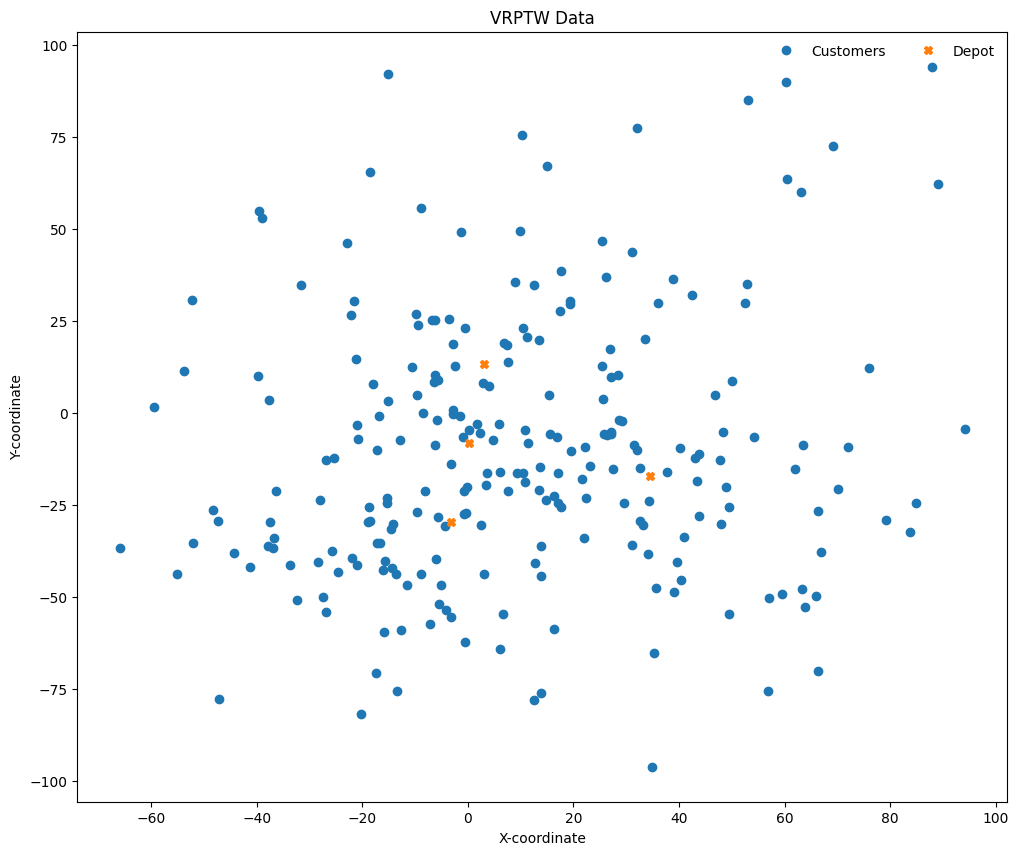

In [274]:
plot_data(data)

## Solution state

In [275]:
class CvrptwState:
    """
    Solution state for CVRPTW. It has two data members, routes and unassigned.
    Routes is a list of list of integers, where each inner list corresponds to
    a single route denoting the sequence of customers to be visited. A route
    does not contain the start and end depot. Times is a list of list, containing
    the planned arrival times for each customer in the routes. The outer list
    corresponds to the routes, and the inner list corresponds to the customers of
    the route. Unassigned is a list of integers, each integer representing an 
    unassigned customer.
    """

    def __init__(self, routes, times, unassigned=None):
        self.routes = routes
        self.times = times     # planned arrival times for each customer
        self.unassigned = unassigned if unassigned is not None else []

    def copy(self):
        return CvrptwState(
            copy.deepcopy(self.routes), self.times.copy(), self.unassigned.copy()
        )

    def objective(self):
        """
        Computes the total route costs.
        """
        return sum(route_cost(route) for route in self.routes)

    @property
    def cost(self):
        """
        Alias for objective method. Used for plotting.
        """
        return self.objective()

    def find_route(self, customer):
        """
        Return the route that contains the passed-in customer.
        """
        for route in self.routes:
            if customer in route:
                return route
        # print(f"Solution does not contain customer {customer}.")
    
    def find_index_in_route(self, customer, route):
        """
        Return the index of the customer in the route.
        """
        if customer in route:
            return route.index(customer)

        raise ValueError(f"Given route does not contain customer {customer}.")

    def update_times(self):
        """
        Update the arrival times of each customer in the routes.
        """
        for idx, route in enumerate(self.routes):
            self.times[idx] = self.evaluate_times_of_route(route)

    def evaluate_times_of_route(self, route):
        """
        Update the arrival times of each customer in a given route.
        """
        timings = [0]
        current_position = 0
        for customer in route:
            movement_time = data["edge_weight"][current_position][customer]
            # add the service time of the last customer
            timings.append(timings[-1] + data["service_time"][current_position])
            # add the movement time to reach next customer
            timings[-1] = float(timings[-1] + movement_time)

        return timings

    def print_state_dimensions(self):
        print(f"Number of routes: {len(self.routes)}")
        print(f"Length of routes: {[len(route) for route in self.routes]}")
        print(f"Dimensions of times: {[len(route) for route in self.times]}")
        print(f"Number of unassigned customers: {len(self.unassigned)}")
        print(f"Number of customers in routes: {sum(len(route) for route in self.routes)}")


# NOTE: maybe add time influence on cost of solution ?
def route_cost(route):
    distances = data["edge_weight"]
    tour = [0] + route + [0]

    return sum(
        distances[tour[idx]][tour[idx + 1]] for idx in range(len(tour) - 1)
    )

In [276]:
def get_customer_info(data, state: CvrptwState, idx):
    """
    Get the customer information for the passed-in index.
    """
    route = state.find_route(idx)
    index_in_route = state.find_index_in_route(idx, route)
    route_index = state.routes.index(route)
    print(f"index_in_route: {index_in_route}")
    print(f"route: {route}")
    planned_service_time = state.times[route_index][index_in_route]

    dict = {
        "index": idx,
        "coords": data["node_coord"][idx],
        "demand": data["demand"][idx].item(),
        "ready time": data["time_window"][idx, 0].item(),
        "due time": data["time_window"][idx, 1].item(),
        "service_time": data["service_time"][idx].item(),
        "route": route,
        "planned service time": planned_service_time,
    }

    return dict

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [277]:
degree_of_destruction = 0.05
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)
print(f"Removing {customers_to_remove} customers.")

Removing 11 customers.


In [278]:
def random_removal(state, rng):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    destroyed = state.copy()

    for customer in rng.choice(
        range(data["dimension"]), customers_to_remove, replace=False
    ):
        destroyed.unassigned.append(customer)
        route = destroyed.find_route(customer)
        if route is not None:
            route.remove(customer)

    # NOTE: now evaluate the time of the modified routes and return them
    destroyed.update_times()

    return remove_empty_routes(destroyed)


def remove_empty_routes(state):
    """
    Remove empty routes and timings after applying the destroy operator.
    """
    routes_idx_to_remove = [idx for idx, route in enumerate(state.routes) if len(route) == 0]
    state.routes = [route for idx, route in enumerate(state.routes) if idx not in routes_idx_to_remove] 
    state.times = [timing for idx, timing in enumerate(state.times) if idx not in routes_idx_to_remove]
    state.times = [timing for idx, timing in enumerate(state.times) if len(state.routes[idx]) != 0]
    return state

## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost. Time window constraints are implemented as follows in the **greedy repair**:

1)  Within the set of unvisited nodes, first find those nodes that can be visited within the node's time window from the current end of each existing route
2)  Add the node that is nearest to the end of some route to that route
3)  If no unvisited nodes can be visited on time, make a new route just for that node

In [279]:
def greedy_repair(state, rng):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created. Only checks capacity constraints.
    """
    rng.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert(customer, state)

        if route is not None:
            route.insert(idx, customer.item())
            state.update_times()
            # DEBUG
            # print(f"\nCustomer {customer} inserted in route {route} at position {idx}.")
            # print(f"Planned service time for customer {customer}: {state.times[state.routes.index(route)][idx]}")
            # print(f"Requested time window: {data['time_window'][customer]}\n")
        else:
            # Initialize a new route and corresponding timings
            # Check if the number of routes is less than the number of vehicles
            if len(state.routes) < data["vehicles"]:
                state.routes.append([customer.item()])
                state.times.append([0])
                state.update_times()    # NOTE: maybe not needed
            else:
                print(f"Customer {customer} could not be inserted in any route. Maximum number of routes/vehicles reached.")

    return state

def greedy_repair_tw(state, rng):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created. Check capacity and time window constraints.
    """
    rng.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert_tw(customer, state)

        if route is not None:
            route.insert(idx, customer.item())
            state.update_times()
        else:
            # Initialize a new route and corresponding timings
            # Check if the number of routes is less than the number of vehicles
            if len(state.routes) < data["vehicles"]:
                state.routes.append([customer.item()])
                state.times.append([0])
                state.update_times()    # NOTE: maybe not needed
            else:
                print(f"Customer {customer} could not be inserted in any route. Maximum number of routes/vehicles reached.")

    return state


def best_insert(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    Only checks capacity constraints.
    """
    best_cost, best_route, best_idx = None, None, None

    for route_number, route in enumerate(state.routes):
        for idx in range(len(route) + 1):
            # DEBUG
            # print(f"In best_insert: route_number = {route_number}, idx = {idx}")
            if can_insert(customer, route_number, idx, state):
                cost = insert_cost(customer, route, idx)             

                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


def best_insert_tw(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    Checks both capacity and time window constraints.
    """
    best_cost, best_route, best_idx = None, None, None

    for route_number, route in enumerate(state.routes):
        for idx in range(len(route) + 1):
            # DEBUG
            # print(f"In best_insert: route_number = {route_number}, idx = {idx}")
            if can_insert_tw(customer, route_number, idx, state):
                cost = insert_cost(customer, route, idx)

                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


# NOTE: I think performance can be improved by changing this function
def can_insert(customer, route_number, idx, state):
    """
    Checks if inserting customer in route 'route_number' at position 'idx' does not exceed vehicle capacity.
    """
    route = state.routes[route_number]

    # Capacity check
    total = data["demand"][route].sum() + data["demand"][customer]
    if total > data["capacity"]:
        return False
    return True


# NOTE: I think performance can be improved by changing this function
def can_insert_tw(customer, route_number, idx, state):
    """
    Checks if inserting customer in route 'route_number' at position 'idx' does not exceed vehicle capacity and time window constraints.
    """

    route = state.routes[route_number]
    # Capacity check
    total = data["demand"][route].sum() + data["demand"][customer]
    if total > data["capacity"]:
        return False
    # Time window check
    if time_window_check(state.times[route_number][idx - 1], route[idx - 1], customer):
        return route_time_window_check(route, state.times[route_number])


def route_time_window_check(route, times):
    """
    Check if the route satisfies time-window constraints. Ignores the depots as
    they are considered available 24h.
    """
    route = route[1:] # Ignore the depot
    for idx, customer in enumerate(route):
        if times[idx] > data["time_window"][customer][1]:
            return False

    return True

# NOTE: this is a terrible check.
# It will accept any customer whose time window is after the calculated arrival time,
# even if the vehicle is early.
# Is the vehicle allowd to be early?
def time_window_check(prev_customer_time, prev_customer, candidate_customer):
    """
    Check if the candidate customer satisfies time-window constraints. Ignores the depots as
    they are considered available 24h.
    """
    return prev_customer_time + data["service_time"][prev_customer] + data[
        "edge_weight"][prev_customer][candidate_customer] <= data["time_window"][candidate_customer][1]

def insert_cost(customer, route, idx):
    """
    Computes the insertion cost for inserting customer in route at idx.
    """
    dist = data["edge_weight"]
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]

    # Increase in cost of adding customer, minus cost of removing old edge
    return dist[pred][customer] + dist[customer][succ] - dist[pred][succ]

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

### Choosing starting depot
If the number of vehicles if larger than number of depots we split the number of vehicles between the depots.

Otherwise, we choose randomly a depot and generate a route from it.
NOTE: maybe performance of the model can be improved by changing the above policy

In [280]:
def calculate_depots(data):
    """
    Calculate the depot index for the vehicles. If the number of vehicles is equal to the number of depots,
    then vehicle i is mapped to depot i. If the number of vehicles is greater than the number of depots, then
    round robin assignment is used. If the number of vehicles is less than the number of depots, then random
    assignment is used, but load balancing between depots is guaranteed. The mapping is stored in the data
    dictionaries "depot_to_vehicles" and "vehicle_to_depot".
    """
    n_customers = data['dimension']
    n_vehicles = data["vehicles"]
    n_depots = data["n_depots"]
    depots = data["depots"]
    # print(f"Number of customers: {n_customers}")
    # print(f"Before, depot to vehicles: {data['depot_to_vehicles']}")
    # Initialization of the dictionaries
    for depot in depots:
        data["depot_to_vehicles"][depot] = []
    for vehicle in range(n_vehicles):
        data["vehicle_to_depot"][vehicle] = None
    # vehicle i -> depot i
    if n_vehicles == n_depots:  
        for depot in depots:
            data["depot_to_vehicles"][depot].append(depot)
            data["vehicle_to_depot"][depot] = depot

    elif n_vehicles > n_depots:
        # Round robin assignment
        for vehicle in range(n_vehicles):
            depot = vehicle % n_depots
            # print(f"Vehicle {vehicle} assigned to depot {depot}.")
            # print(f"Depot to vehicles: {data['depot_to_vehicles']}")
            # print(f"After, depot to vehicles: {data['depot_to_vehicles']}")
            # print(f"n_customer + depot: {n_customers + depot}") 
            data["depot_to_vehicles"][n_customers + depot].append(vehicle)
            data["vehicle_to_depot"][vehicle] = n_customers + depot
    else:
        # Random assignment
        depots = rnd.choice(depots, size=n_vehicles, replace=False)
        for vehicle in range(n_vehicles):
            depot = depots[vehicle]
            data["depot_to_vehicles"][depot].append(vehicle)
            data["vehicle_to_depot"][vehicle] = int(depot)

In [281]:
calculate_depots(data)
print(data['depot_to_vehicles'])
print(data['vehicle_to_depot'])
print(data['dimension'])

{240: [0, 4], 241: [1, 5], 242: [2], 243: [3]}
{0: 240, 1: 241, 2: 242, 3: 243, 4: 240, 5: 241}
240


In [282]:
def neighbors(customer, depots: list = []):
    """
    Return the nearest neighbors of the customer, excluding the depot.
    """
    locations = np.argsort(data["edge_weight"][customer])
    return [loc for loc in locations if loc not in depots]

def nearest_neighbor_tw():
    """
    Build a solution by iteratively constructing routes, where the nearest
    time-window compatible customer is added until the route has met the 
    vehicle capacity limit.
    """
    routes = []
    full_schedule = []
    unvisited = set(range(data["dimension"]))
    vehicle = 0

    while unvisited and vehicle < data["vehicles"]:
        # Mapping vehicle i to depot i
        calculate_depots(data)

        initial_depot = data["vehicle_to_depot"][vehicle]
        route = [initial_depot]  # Start at the depot
        route_schedule = [0]
        route_demands = 0
        print(f"Route of vehicle {vehicle} starts at depot {initial_depot}")
        while unvisited:
            # Add the nearest unvisited customer to the route till max capacity
            current = route[-1]
            # print(f"current = {current}")
            # print(
            #     f"len(neighbors({current})), len(unvisited) = {len(neighbors(current, depots=data['depots']))}, {len(unvisited)}"
            # )
            # print(f"unvisited = {unvisited}")
            nearest = [nb for nb in neighbors(current, depots=data['depots']) if nb in unvisited][0]
            nearest = int(nearest)
            # print(f"nearest = {nearest}")

            if route_demands + data["demand"][nearest] > data["capacity"]:
                break

            if not time_window_check(route_schedule[-1], current, nearest):
                break
            if not route_time_window_check(route, route_schedule):
                break

            route.append(nearest)
            route_schedule.append(
                data["edge_weight"][current][nearest].item()
                + data["service_time"][current].item()
            )

            unvisited.remove(nearest)
            route_demands += data["demand"][nearest]

        # customers = route[1:]  # Remove the depot
        # routes.append(customers)
        routes.append(route)
        full_schedule.append(route_schedule)
        # Consider new vehicle
        vehicle += 1

    if unvisited:
        print(f"Unvisited customers: {unvisited}")
    if vehicle < data["vehicles"]:
        print(f"Vehicles left: {data['vehicles'] - vehicle}")

    return CvrptwState(routes, full_schedule)

Route of vehicle 0 starts at depot 240
Route of vehicle 1 starts at depot 241
Route of vehicle 2 starts at depot 242
Route of vehicle 3 starts at depot 243
Route of vehicle 4 starts at depot 240
Route of vehicle 5 starts at depot 241
Unvisited customers: {0, 1, 2, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 20, 21, 24, 26, 30, 33, 35, 36, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 60, 64, 66, 67, 68, 69, 70, 73, 75, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 94, 95, 96, 97, 102, 103, 104, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 131, 132, 133, 135, 136, 137, 138, 139, 140, 143, 144, 146, 147, 148, 149, 151, 152, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 177, 179, 180, 181, 183, 185, 188, 190, 191, 194, 198, 199, 200, 203, 204, 207, 208, 209, 210, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 

/tmp/ipykernel_44660/4255142459.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("Set2", data['vehicles'])


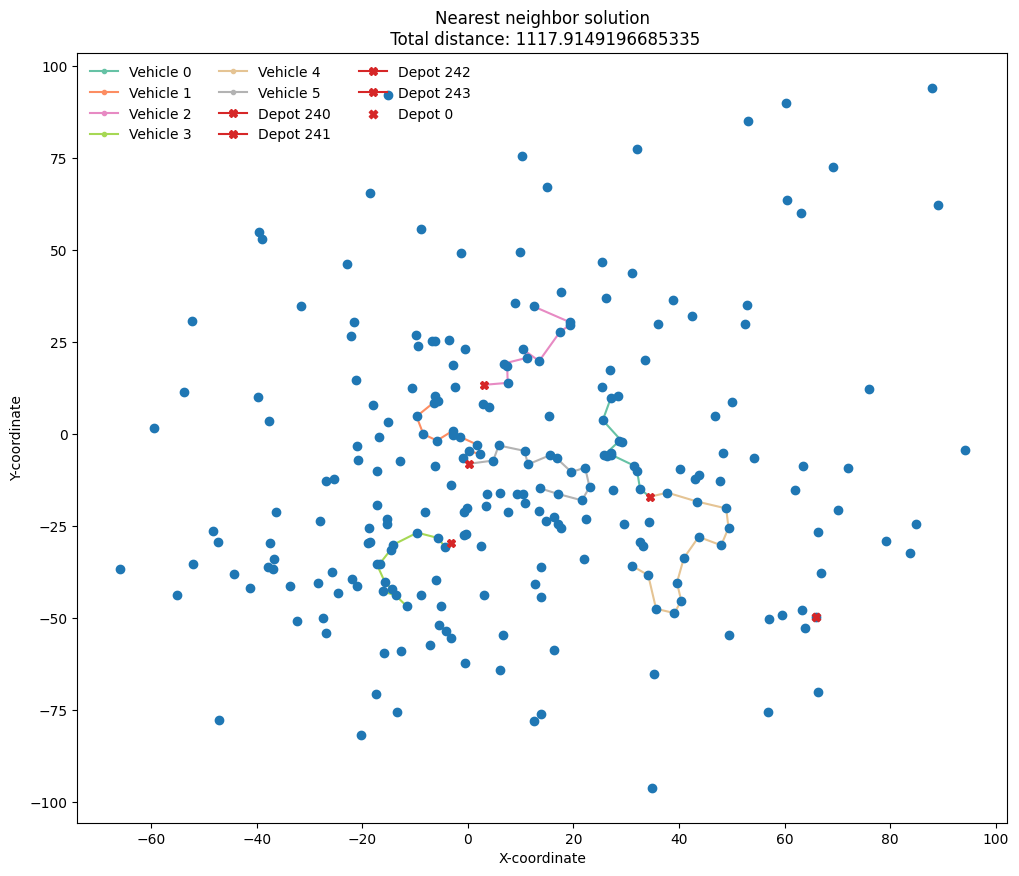

In [283]:
initial_solution = nearest_neighbor_tw()

plot_solution(initial_solution, "Nearest neighbor solution")

In [284]:
def verify_time_windows(state):
    """
    Counts the number of customers that are served late or early in the solution.
    """
    late, early, ontime = 0, 0, 0
    planned_customers = [customer for route in state.routes for customer in route]
    planned_customers = [customer for customer in planned_customers if customer not in data["depots"]]
    left_out_customers = [customer for customer in range(data["dimension"]) if customer not in planned_customers]
    for customer in planned_customers:
        route = state.find_route(customer)
        idx = state.find_index_in_route(customer, route)
        arrival_time = state.times[state.routes.index(route)][idx]
        due_time = data["time_window"][customer][1]
        ready_time = data["time_window"][customer][0]
        if arrival_time > due_time:
            late += 1
        elif arrival_time < ready_time:
            early += 1
        elif arrival_time >= ready_time and arrival_time <= due_time:
            ontime += 1
    return late, early, ontime, len(left_out_customers)


late, early, ontime, left_out = verify_time_windows(initial_solution)
print(f"Late: {late}, Early: {early}, Ontime: {ontime}")
print(f"Left out customers because of not enough routes/vehicles: {left_out}")

Late: 0, Early: 71, Ontime: 0
Left out customers because of not enough routes/vehicles: 169


## Heuristic solution

Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we do not actually use any adaptive operator selection -- but you can easily add more destroy and repair operators. 

In [285]:
alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(random_removal)

alns.add_repair_operator(greedy_repair)

In [286]:
num_iterations = 5000
init = nearest_neighbor_tw()
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)
result = alns.iterate(init, select, accept, stop)

Route of vehicle 0 starts at depot 240
Route of vehicle 1 starts at depot 241
Route of vehicle 2 starts at depot 242
Route of vehicle 3 starts at depot 243
Route of vehicle 4 starts at depot 240
Route of vehicle 5 starts at depot 241
Unvisited customers: {0, 1, 2, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 20, 21, 24, 26, 30, 33, 35, 36, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 60, 64, 66, 67, 68, 69, 70, 73, 75, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 94, 95, 96, 97, 102, 103, 104, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 131, 132, 133, 135, 136, 137, 138, 139, 140, 143, 144, 146, 147, 148, 149, 151, 152, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 177, 179, 180, 181, 183, 185, 188, 190, 191, 194, 198, 199, 200, 203, 204, 207, 208, 209, 210, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 

In [287]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

Best heuristic objective is 1100.3331988937327.


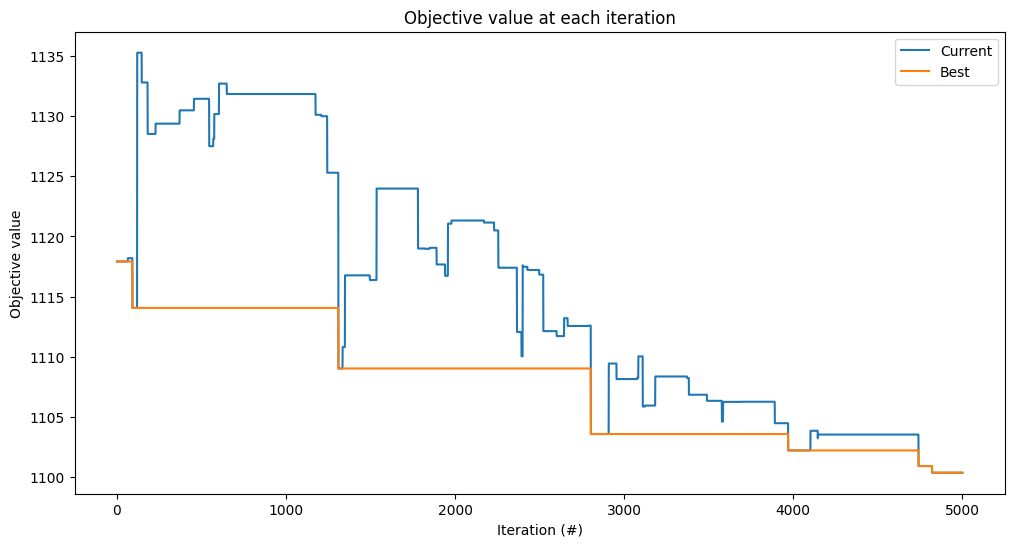

In [288]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

/tmp/ipykernel_44660/4255142459.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("Set2", data['vehicles'])


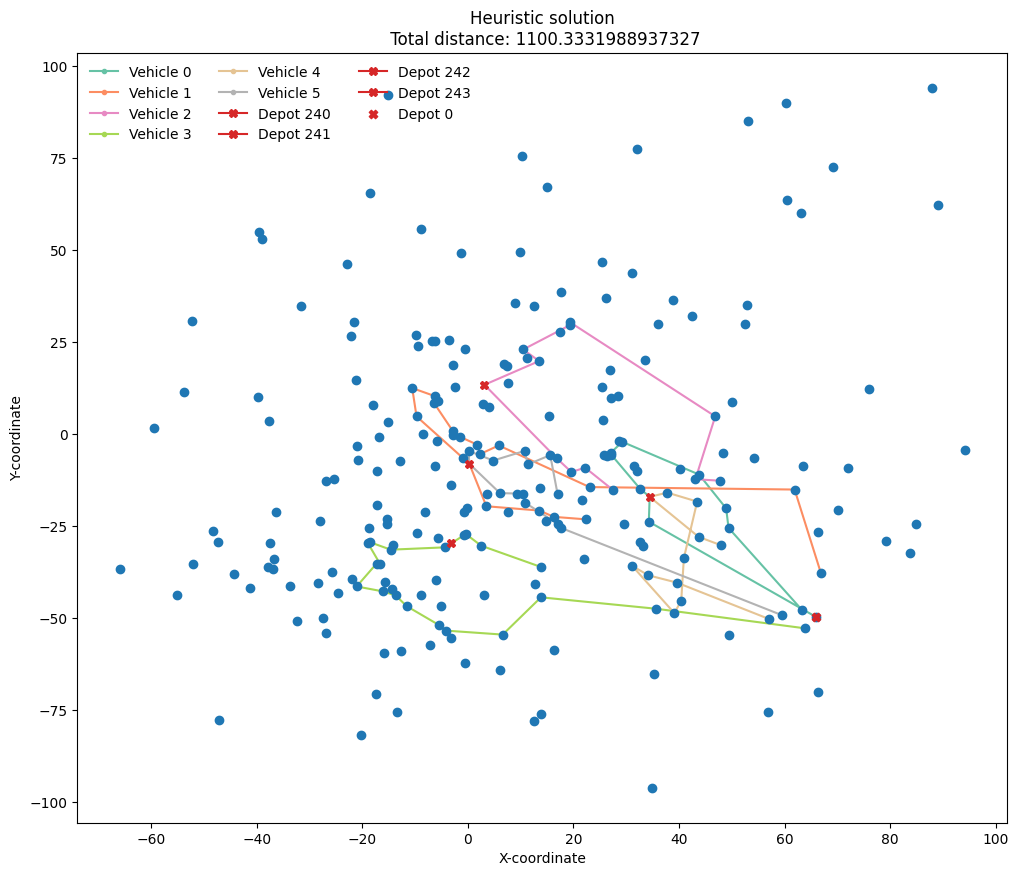

In [289]:
plot_solution(solution, "Heuristic solution", idx_annotations=False)